## automatic emittance meas

In [1]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../../")
    sys.path.append("../../")

run_dir = "/home/physics3/ml_tuning/20230825_LCLS_Injector/"
print(sys.path)

import os
os.environ["OMP_NUM_THREADS"] = str(6)

['/home/physics3/rroussel/SLAC_Xopt/lcls/emittance/emittance_optimization', '/usr/local/lcls/tools/python/toolbox', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python39.zip', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/lib-dynload', '', '/home/physics3/.local/lib/python3.9/site-packages', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages', '../../../', '../../']


In [2]:
from scripts.image import ImageDiagnostic
import yaml

fname = "../../OTR3_config.yml"
image_diagnostic = ImageDiagnostic.parse_obj(yaml.safe_load(open(fname)))
image_diagnostic.save_image_location = run_dir
image_diagnostic.n_fitting_restarts = 2
image_diagnostic.visualize = False
image_diagnostic.threshold = 20
image_diagnostic.background_file = run_dir + "OTRS_IN20_621_background.npy"
print(image_diagnostic.yaml())

{screen_name: 'OTRS:IN20:621', array_data_suffix: IMAGE, array_n_cols_suffix: ROI_XNP,
  array_n_rows_suffix: ROI_YNP, resolution_suffix: RESOLUTION, resolution: 1.0, beam_shutter_pv: 'IOC:BSY0:MP01:MSHUTCTL',
  background_file: /home/physics3/ml_tuning/20230825_LCLS_Injector/OTRS_IN20_621_background.npy,
  save_image_location: /home/physics3/ml_tuning/20230825_LCLS_Injector/, roi: null,
  min_log_intensity: 4.0, bounding_box_half_width: 3.0, wait_time: 0.1, n_fitting_restarts: 2,
  visualize: false, return_statistics: false, threshold: 20, testing: false}



{'Cx': 238.51677342477618,
 'Cy': 214.73611279448394,
 'Sx': 53.804660176116116,
 'Sy': 75.21129053196611,
 'bb_penalty': -171.3766286459977,
 'total_intensity': 14809.4,
 'log10_total_intensity': 4.170537463520015}

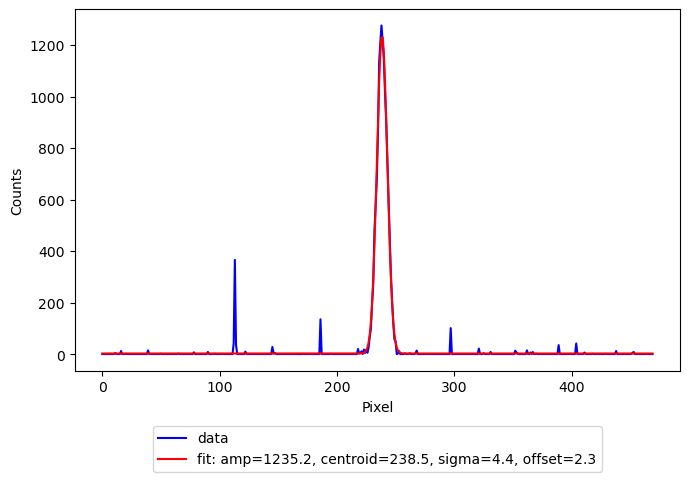

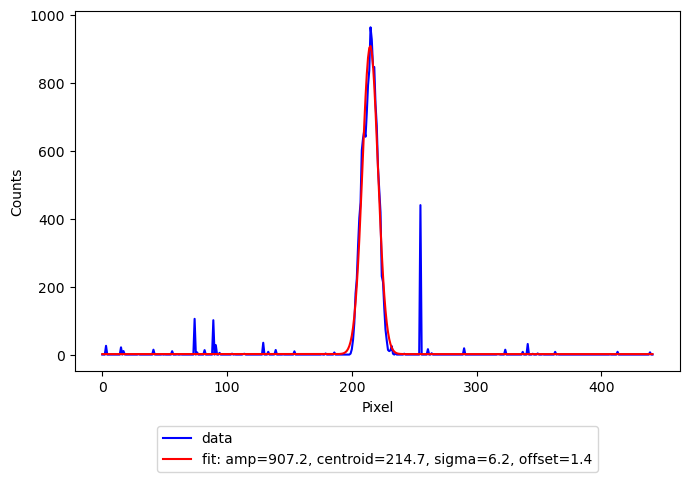

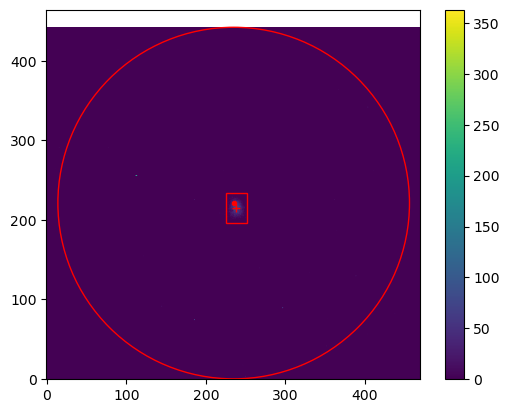

In [3]:
image_diagnostic.test_measurement()

In [4]:
from scripts.automatic_emittance import ScreenEmittanceMeasurement, BeamlineConfig

drift_length = 4.123114
beamline_config = BeamlineConfig(
    scan_quad_pv="QUAD:IN20:525:BCTRL",
    scan_quad_range=[-10.0, 1.0],
    scan_quad_length=0.1068,
    transport_matrix_x =[[1.0,    drift_length],
        [ 0.0,    1.0]],
    transport_matrix_y = [[1.0,    drift_length],
        [ 0.0,    1.0]],
    beam_energy=0.135,
    design_beta_x = 4.68280051,
    design_beta_y = 4.68872767,
    design_alpha_x = -1.79636538,
    design_alpha_y = -1.79814306
)


measurement = ScreenEmittanceMeasurement(
    image_diagnostic=image_diagnostic,
    beamline_config=beamline_config,
    run_dir=run_dir,
    wait_time=3.0,
    n_shots=10,
    n_iterations=5,
    visualize=True,
    turbo_length=2.0
)

measurement.dump_yaml()

In [5]:
from epics import caput, caget
from time import sleep
import numpy as np
def eval_emittance(inputs):
    global measurement

    # get current value of measurement pv
    old_meas_value = caget(measurement.beamline_config.scan_quad_pv)

    # set PVs
    for k, v in inputs.items():
        print(f'CAPUT {k} {v}')
        caput(k, v)

    sleep(5.0)
    print("starting emittance measurement")
    results, emit_x = measurement.run()

    # reset measurement pv
    print("resetting measurement PV value")
    caput(measurement.beamline_config.scan_quad_pv, old_meas_value)

    ex = results["x_emittance"]
    ex_var = results["x_emittance_var"]
    ey = results["y_emittance"]
    ey_var = results["y_emittance_var"]

    results["geo_mean_emit"] = np.sqrt(ex*ey)
    results["geo_mean_emit_var"] = 0.25*(ey**2 * ex_var + ex**2 * ey_var)/(ex*ey)
    results["emit_measurement_file"] = measurement.dump_file

    return results
    

In [6]:
import pandas as pd
filename = "../../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')

from xopt import VOCS
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL","QUAD:IN20:122:BCTRL"]
vocs = VOCS(
        variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
        objectives = {"geo_mean_emit": "MINIMIZE"},
    )
print(vocs)

variables={'SOLN:IN20:121:BCTRL': [0.377, 0.498], 'QUAD:IN20:121:BCTRL': [-0.021, 0.021], 'QUAD:IN20:122:BCTRL': [-0.021, 0.021]} constraints={} objectives={'geo_mean_emit': 'MINIMIZE'} constants={} observables=[]


In [7]:
from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

# remember to set use low noise prior to false!!!
model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = UpperConfidenceBoundGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
    turbo_controller="optimize"
)
evaluator = Evaluator(function=eval_emittance)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.options.dump_file = run_dir + "emittance_optimization_2.yml"
X


            Xopt
________________________________
Version: 2.0a1+78.gd113821
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: true, dump_file: /home/physics3/ml_tuning/20230825_LCLS_Injector/emittance_optimization_2.yml,
  max_evaluations: null}
generator:
  name: upper_confidence_bound
  model: null
  turbo_controller:
    dim: 3
    batch_size: 1
    length: 0.25
    length_min: 0.0078125
    length_max: 2.0
    failure_counter: 0
    failure_tolerance: 2
    success_counter: 0
    success_tolerance: 2
    center_x: null
    scale_factor: 2.0
    tkwargs: {dtype: torch.float64}
    minimize: true
    best_value: null
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: false
    covar_modules: {}
    mean_modules: {}
    trainable_mean_keys: []
  numerical_optimizer: {name: LBFGS, n_raw_samples: 20, n_restarts: 20, max_iter: 2000}
  max_travel_distances: null
  fixed_features: null
  computation_time: {}
  n_candidates: 1
  n_monte_carlo_sampl

CAPUT SOLN:IN20:121:BCTRL 0.4755556
CAPUT QUAD:IN20:121:BCTRL -5.4210109e-20
CAPUT QUAD:IN20:122:BCTRL 0.0032420044
starting emittance measurement
sampling points for x emittance
CAPUT QUAD:IN20:525:BCTRL -4.8686214
CAPUT QUAD:IN20:525:BCTRL -1.2020254135131836
CAPUT QUAD:IN20:525:BCTRL -4.905657768249512
CAPUT QUAD:IN20:525:BCTRL -4.979290962219238
CAPUT QUAD:IN20:525:BCTRL -5.081756591796875
CAPUT QUAD:IN20:525:BCTRL -5.234983921051025
CAPUT QUAD:IN20:525:BCTRL -5.421874046325684
CAPUT QUAD:IN20:525:BCTRL -5.832533836364746
0.04367162387372245
80
sampling points for y emittance
CAPUT QUAD:IN20:525:BCTRL -4.591552734375
CAPUT QUAD:IN20:525:BCTRL -6.059859275817871
CAPUT QUAD:IN20:525:BCTRL -5.920020580291748
CAPUT QUAD:IN20:525:BCTRL -4.544032096862793
CAPUT QUAD:IN20:525:BCTRL -4.439019680023193
0.05312476313366829
130


/home/physics3/rroussel/SLAC_Xopt/lcls/emittance/emittance_optimization/../../../scripts/characterize_emittance.py:621: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k = torch.tensor(k, **tkwargs)
/home/physics3/rroussel/SLAC_Xopt/lcls/emittance/emittance_optimization/../../../scripts/characterize_emittance.py:622: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, **tkwargs)
/home/physics3/rroussel/SLAC_Xopt/lcls/emittance/emittance_optimization/../../../scripts/characterize_emittance.py:621: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(s

resetting measurement PV value


,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,x_emittance,x_emittance_05,x_emittance_95,x_emittance_var,bmag_x_median,y_emittance,y_emittance_05,y_emittance_95,y_emittance_var,bmag_y_median,geo_mean_emit,geo_mean_emit_var,emit_measurement_file,xopt_runtime,xopt_error
1,0.475556,-5.421011e-20,0.003242,0.180613,0.165439,0.193802,0.000075,1.005605,0.073909,0.021498,0.125152,0.001132,4.924212,0.115537,0.000699,/home/physics3/ml_tuning/20230825_LCLS_Injecto...,126.607433,False


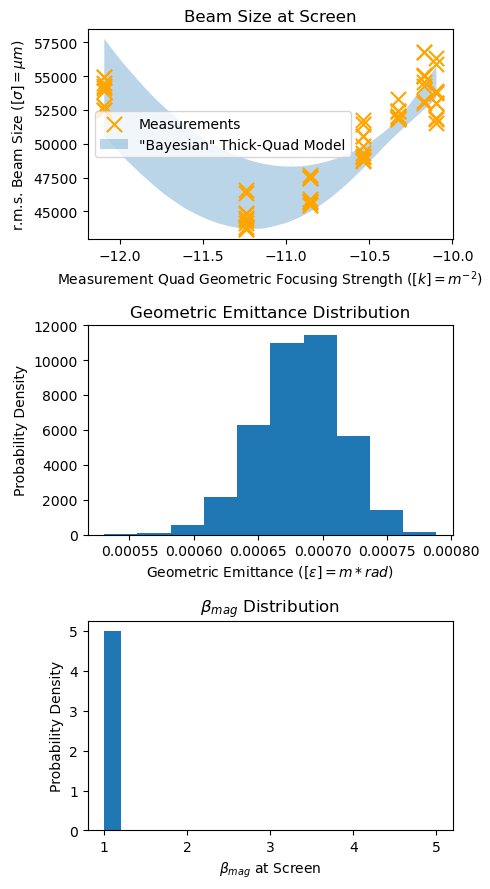

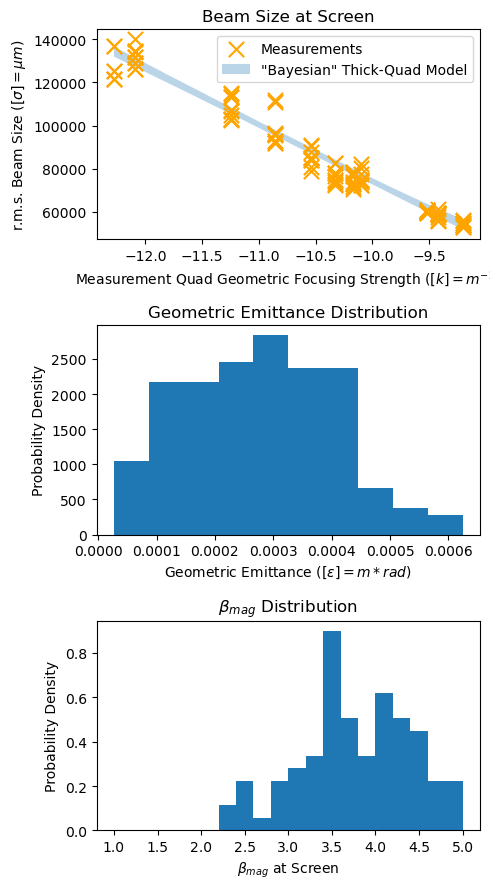

In [8]:
default = {'SOLN:IN20:121:BCTRL': 0.4755556,
 'QUAD:IN20:121:BCTRL': -5.4210109e-20,
 'QUAD:IN20:122:BCTRL': 0.0032420044,
}

X.evaluate_data(pd.DataFrame(default, index=[0]))

In [9]:
X.data.keys()

Index(['SOLN:IN20:121:BCTRL', 'QUAD:IN20:121:BCTRL', 'QUAD:IN20:122:BCTRL',
       'x_emittance', 'x_emittance_05', 'x_emittance_95', 'x_emittance_var',
       'bmag_x_median', 'y_emittance', 'y_emittance_05', 'y_emittance_95',
       'y_emittance_var', 'bmag_y_median', 'geo_mean_emit',
       'geo_mean_emit_var', 'emit_measurement_file', 'xopt_runtime',
       'xopt_error'],
      dtype='object')

<ErrorbarContainer object of 3 artists>

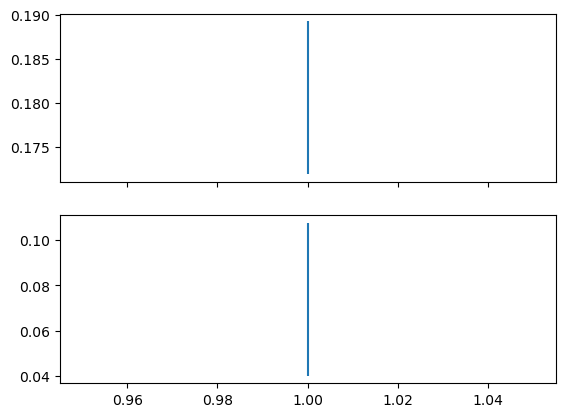

In [10]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,1,sharex="all")
ax[0].errorbar(X.data.index, X.data["x_emittance"], X.data["x_emittance_var"]**0.5)
ax[1].errorbar(X.data.index, X.data["y_emittance"], X.data["y_emittance_var"]**0.5)

In [11]:
pd.DataFrame(X.data.iloc[-1][X.vocs.variable_names]).T

,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,SOLN:IN20:121:BCTRL
1,-0.0,0.003242,0.475556


In [12]:
X.data

,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,x_emittance,x_emittance_05,x_emittance_95,x_emittance_var,bmag_x_median,y_emittance,y_emittance_05,y_emittance_95,y_emittance_var,bmag_y_median,geo_mean_emit,geo_mean_emit_var,emit_measurement_file,xopt_runtime,xopt_error
1,0.475556,-5.421011e-20,0.003242,0.180613,0.165439,0.193802,0.000075,1.005605,0.073909,0.021498,0.125152,0.001132,4.924212,0.115537,0.000699,/home/physics3/ml_tuning/20230825_LCLS_Injecto...,126.607433,False


{'Cx': 240.18578138638492,
 'Cy': 215.37209810122633,
 'Sx': 57.63452249201799,
 'Sy': 81.27453168071477,
 'bb_penalty': -169.0508576373614,
 'total_intensity': 13497.399999999998,
 'log10_total_intensity': 4.130250118539348}

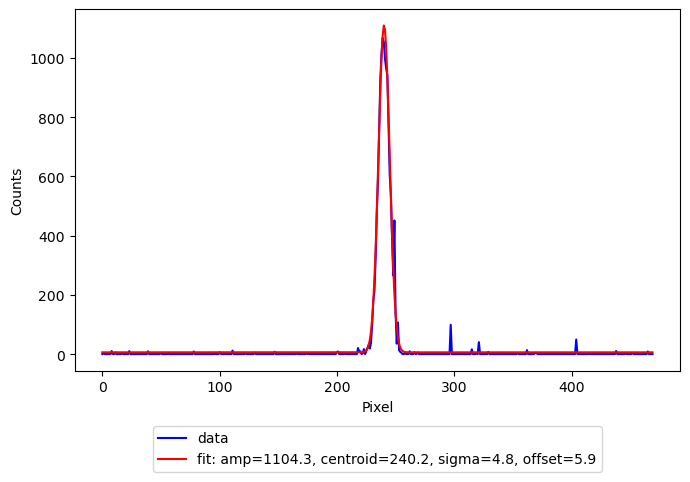

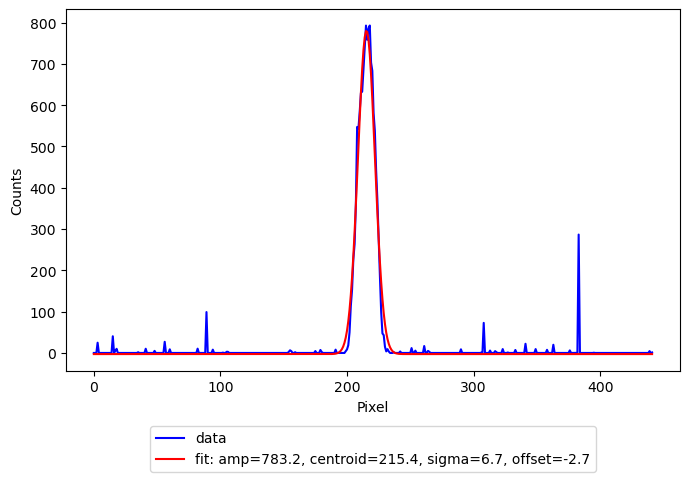

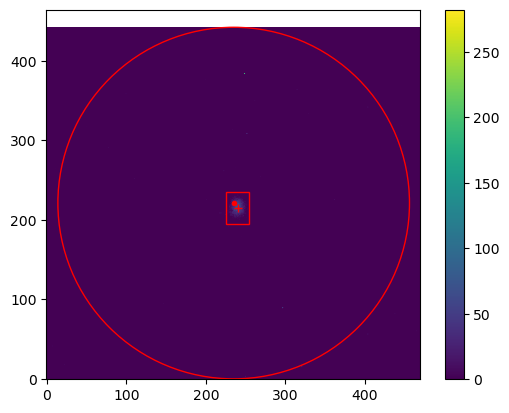

In [13]:
image_diagnostic.test_measurement()